In [1]:
%matplotlib inline

In [46]:
import numpy as np
from timeit import timeit
import matplotlib.pyplot as plt
from scipy import stats

# HyperLogLog

How many people read my new blog post? What percentage of them are newcomers and what - my own audience? 

This data gives insights into whether the article is useful for a website`s target audience or if it attracts different kinds of readers. It is important for authors and digital marketing specialists to know all these details in order to direct their efforts in the right direction.

However, with millions of people consuming articles and social media posts every day, measuring unique users demands more and more resources. 

## Data structures

HyperLogLog is an algorithm and data structure that is born to solve this problem. 

As a data structure (like the other data structures such as arrays, linked list, stacks, queues, etc.) it has its own way of organizing and storing data so that different operations on the stored data can be performed later [[1]](#Cell1).

But HyperLogLog goes beyond the limitations of data structures. It is a probabilistic data structure. Therefore, it relies on a form of probability by using randomness and hasing to reach an approximate solution. 

Probabilistic data structures are preferred when the data becomes very large. They usually consume less memory and have better execution time. But this type of data structure gives an approximate solution with some probability of error. [[2]](#Cell2)

(Alessandro Nadalin shares an interesting opinion. According to him HyperLogLog is an algorithm first (i.e. a set of rules), after that - a data structure - because some databases (eg. Redis, Riak, BigQuery) have implemented their own data structures based on it [[11]](#Cell11)) 

## HyperLogLog

As already mentioned, when data grows bigger, there is a need for more memory and computation in order to count the distinct elements (the cardinality) in it. This is the aim of HyperLogLog - counting how many distinct elements exist in a large dataset approximately - faster and by consuming less amount of memory.

### Essence

(The explanation below is partly based on the HyperLogLog reviews of Gaurav Sen [[5]](#Cell5), Gonzalo Bordanzi
 [[6]](#Cell6) and Brian Kihoon Lee [[8]](#Cell8)).

When users make a connection, their entry is saved in a table. After that, they are checked (in a second table) if they are unique.
So, there is a lot of information duplicated. 

HyperLogLog does something else. It gives them uniformly distributed and random user IDs. These numbers are 32-bit binary 
numbers.
So, at one position of this number the digit will be either 0 or 1. The probability to be zero will be half (½). Therefore, at two positions(next to each other) there will be two zeros ¼ of the times. 
The probability for zeros (at three positions, etc.) can be calculated by the formula:

$$ 2 ^ n $$   

n = number of positions

For example - the probability for binary number with 0000 is:

$ 2 ^ 4 $

#### Buckets

What will happen when a number with 5 zeros emerges (which occurs according to the formula above once in 32 times), but there are only ... four requests?

So, the requests go into buckets. The algorithm divides the numbers in 2, using the first section (the first 5 bits) to address a bucket, and 
the second one (the rest 27 bits) to count the leading zeros. 

Just as an example - 2-bit first section will lead to four buckets (with names = the first two possible digits of the numbers - 00, 01, 10, 11).

For every bucket, HyperLogLog finds the maximum number of leading zeros in the second section (met in some userID). After that, it counts the harmonic mean of the maximum zeros of all the buckets.

#### Harmonic mean

What is harmonic mean (H)?

$$ H = \frac {n} {\frac {1}{x_{1}} + \frac {1}{x_{2}} + \frac {1}{x_{3}} + ... + \frac {1}{x_{n}}} $$

n = the number of numbers, x = any positive real number

The harmonic mean is one of the Pythagorean means. In comparison with the arithmetic mean, it  mitigates the influence of large outliers. If, for example, there are maximum 2, 3, 4, and 10 leading zeros in the four bucket above, then their harmonic mean is:

$ H = \frac {4} {\frac {1}{2} + \frac {1}{3} + \frac {1}{4} + \frac {1}{10}} =  \approx 3.38 $

It can be easily found with the Harmonic Mean function in Python (scipy.stats.hmean):

In [47]:
print(stats.hmean([2, 3, 4, 10]))

3.380281690140845


However, the arithmetic mean of 2, 3, 4, and 10 is:

In [44]:
print(np.mean([2, 3, 4, 10]))

4.75


Flajolet et al. write about the harmonic mean: "... such means have the effect of taming probability distributions with slow-decaying right tails, and here they operate as a 
variance reduction device, thereby appreciably increasing the quality of estimates."[[3]](#Cell3)).

The use of harmonic mean leads to increasing the accuracy of the estimate  - from relative error 1.30/√m in LogLog (the HyperLogLog ancestor, where geometric mean is used) to 1.04/√m now, see [[3]](#Cell3) ). M in the formula is the number of registers. For example, with 12-bit registers m = 212 = 4096 and the relative error is 1.625% [[4]](#Cell4).

#### A practical example

The logic behind HyperLogLog can be easily understood with the example of tossing a coin. It appeared for the first time on this website [[7]](#Cell7)) but because the website is not accessible, the explanation from another website is given [[6]](#Cell6)):

<blockquote>Imagine that you’ve been throwing a coin, and counting the amount of uninterrupted run of heads you’ve been getting. If you tell me that your maximum was 3, I can figure that you haven’t been throwing the coin a lot of times. If you tell me it was 10 instead, I will be pretty sure that you’ve thrown the coin a lot of times.</blockquote>

#### HLL++

Later Stefan Heule, Marc Nunkesser, and Alexander Hall from Google present some improvements to the algorithm that they made (known as HLL++) (64-bit hash function, sparse representation of the registers for small cardinalities and a dense representation if the cardinality grows, etc. [[9]](#Cell9)). 

## Tests

#### A Reddit test

Reddit uses HyperLogLog (by its Redis implementation) to measure new views of the posts on their platform. Krishnan Chandra, Senior Software Engineer at Reddit, gives an example of how much space the algorithm saved [[10]](#Cell10):

<blockquote>... consider the r/pics post included at the top of this blog post. It received over 1 million unique users. If we had to store 1 million unique user IDs, and each user ID is an 8-byte long, then we would require 8 megabytes of memory just to count the unique users for a single post! In contrast, using an HLL for counting would take significantly less memory. The amount of memory varies per implementation, but in the case of this implementation, we could count over 1 million IDs using just 12 kilobytes of space, which would be 0.15% of the original space usage!</blockquote>

#### Own tests

Due to technical problems, Redis won`t be tested. The performance of the algorithm will be shown by means of hyperloglog 
(hyperloglog cardinality counter - written with small letter here as differentiation between the algorithm (with capital letter) and its implementation). 

Because hyperloglog didn't functionate in Jupyter notebook (despite its successful installation in the draft), the code will be run in PyCharm and the results 
will be inserted after the code. 

Below is the code for hyperloglog testing. It uses random.randint in order to get different, unique numbers. The alternative counting of unique numbers used here
(set(list)) not only will give a basis for comparison but also is expected to find 100% of the unique numbers, repeating the number_of_numbers` value (which defines the number of numbers included in every list).

In [ ]:
import random
import timeit
import hyperloglog
from memory_profiler import profile


number_of_numbers = int(input())
time_results_hll = []
time_results_list = []
unique_el_hll = []
unique_el = []

@profile
def random_hhl(hll_random_nm):
    return len(hll_random_nm)

@profile
def random_list(random_nm_list):
    return len(list(set(random_nm_list)))

for tm in range(50):
    hll_random_nm = hyperloglog.HyperLogLog(0.01)
    random_nm_list = []

    for n in range(number_of_numbers):
        random_nm = random.randint(0, 5000)
        hll_random_nm.add(random_nm)
        random_nm_list.append(random_nm)
    result_hll = timeit.timeit('random_hhl(hll_random_nm)', globals=globals(), number=3)
    time_results_hll.append(result_hll)
    unique_el_hll.append(len(hll_random_nm))
    result_list = timeit.timeit('random_list(random_nm_list)', globals=globals(), number=3)
    time_results_list.append(result_list)
    unique_el.append(len(random_nm_list))

print(f"HLL - time: {time_results_hll}, unique elements:{unique_el_hll}")
print(f"Ordinary - time: {time_results_list}, unique elements:{unique_el}")

The attempts to catch the difference in memory consumption of both functions (by using a function decorator) didn`t give results.
The consumption was similar (with similar picks and falls). Perhaps more sensitive measurement methods and more powerful machines (with the ability to cope with bigger numbers) are needed.

In [27]:
# The results prepared directly for graphs - lists of 70 elements
y_hll_70 = [69, 70, 70, 70, 70, 70, 69, 69, 69, 70, 70, 70, 68, 70, 70, 69, 70, 69, 70, 69, 70, 69, 70, 70, 69, 70, 70, 70, 70, 69, 69, 68, 70, 70, 70, 70, 70, 70, 70, 69, 70, 70, 68, 69, 69, 70, 70, 70, 69, 70]
y_list_70 =  [70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70]
x_hll_70 = [8.300000000005525e-05, 7.560000000017553e-05, 7.750000000017465e-05, 7.380000000001274e-05, 8.330000000000837e-05, 7.240000000008351e-05, 7.180000000017728e-05, 7.730000000005788e-05, 7.530000000022241e-05, 7.199999999984996e-05, 7.200000000029405e-05, 0.00012970000000001036, 7.449999999975532e-05, 7.470000000031618e-05, 7.200000000029405e-05, 7.16000000000605e-05, 7.180000000017728e-05, 7.149999999978007e-05, 7.210000000013039e-05, 7.559999999973144e-05, 7.249999999991985e-05, 7.170000000034094e-05, 7.169999999989685e-05, 7.16000000000605e-05, 7.149999999978007e-05, 9.179999999986421e-05, 7.229999999980308e-05, 7.199999999984996e-05, 7.200000000029405e-05, 7.169999999989685e-05, 7.149999999978007e-05, 7.130000000010739e-05, 7.41999999998022e-05, 7.240000000008351e-05, 7.229999999980308e-05, 7.190000000001362e-05, 7.16000000000605e-05, 7.169999999989685e-05, 7.189999999956953e-05, 7.259999999975619e-05, 7.190000000001362e-05, 8.049999999970581e-05, 7.380000000001274e-05, 7.33999999997792e-05, 7.439999999991898e-05, 8.510000000017115e-05, 7.420000000024629e-05, 7.400000000012952e-05, 7.359999999989597e-05, 8.749999999979607e-05]
x_list_70  = [2.0099999999967366e-05, 1.8999999999991246e-05, 1.9500000000061135e-05, 1.819999999996824e-05, 1.9099999999827588e-05, 1.8500000000365446e-05, 1.7900000000015126e-05, 1.8899999999710815e-05, 1.8999999999991246e-05, 1.8400000000085015e-05, 1.8299999999804584e-05, 2.239999999975595e-05, 2.4000000000246047e-05, 1.9099999999827588e-05, 1.8999999999991246e-05, 1.7800000000178784e-05, 1.7800000000178784e-05, 1.7699999999898353e-05, 1.7699999999898353e-05, 1.8900000000154904e-05, 1.7900000000015126e-05, 1.7999999999851468e-05, 1.750000000022567e-05, 1.7800000000178784e-05, 1.8400000000085015e-05, 1.819999999996824e-05, 1.819999999996824e-05, 1.7300000000108895e-05, 1.760000000006201e-05, 1.7700000000342442e-05, 1.7900000000015126e-05, 1.7900000000015126e-05, 1.870000000003813e-05, 1.749999999978158e-05, 1.749999999978158e-05, 1.7399999999945237e-05, 1.7399999999945237e-05, 1.750000000022567e-05, 1.7399999999945237e-05, 1.85999999997577e-05, 1.760000000006201e-05, 2.0500000000200913e-05, 1.9500000000061135e-05, 1.8899999999710815e-05, 1.9899999999850593e-05, 2.140000000006026e-05, 1.7999999999851468e-05, 1.8300000000248673e-05, 1.819999999996824e-05, 7.9200000000057e-05]


# Lists of 700 elements
y_hll = [650, 662, 649, 665, 658, 648, 651, 657, 651, 645, 646, 651, 649, 658, 651, 658, 653, 665, 662, 648, 654, 648, 667, 640, 647, 654, 652, 649, 659, 642, 636, 675, 658, 645, 661, 651, 647, 654, 654, 655, 667, 653, 642, 659, 648, 668, 653, 643, 656, 654] 
y_list = [700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700, 700]
x_hll = [0.00013139999999989271, 0.0001881999999993056, 0.0001239999999995689, 0.00012699999999998823, 0.00012230000000013064, 0.00012319999999998998, 0.00012020000000045883, 0.0001290000000002678, 0.00012280000000064462, 0.0001293000000002209, 0.00012339999999966267, 0.00012180000000050484, 0.0001225000000006915, 0.00012420000000012976, 0.00013020000000008025, 0.00012440000000069062, 0.00015119999999946288, 0.0001250999999999891, 0.0001250999999999891, 0.00012140000000027129, 0.00012709999999938049, 0.00012089999999975731, 0.00012740000000022178, 0.0001487000000004457, 0.00020169999999986032, 0.00014459999999960615, 0.00012839999999947338, 0.0001250999999999891, 0.00012939999999961316, 0.00012150000000055172, 0.0001361000000006385, 0.00013780000000007675, 0.00012369999999961578, 0.0001281999999998007, 0.00012299999999942912, 0.00012159999999994398, 0.00012189999999989709, 0.00012230000000013064, 0.00013829999999970255, 0.00012159999999994398, 0.0001221999999998502, 0.00012249999999980332, 0.00013249999999942474, 0.0001252999999996618, 0.00012319999999998998, 0.0001407999999996079, 0.00012339999999966267, 0.00012089999999975731, 0.00012100000000003774, 0.00011999999999989797]
x_list  = [0.00016689999999996985, 0.00016269999999973805, 0.00016960000000043607, 0.0001661999999997832, 0.00016899999999964166, 0.0001601999999998327, 0.00016009999999955227, 0.00016330000000053246, 0.0001601999999998327, 0.0001648999999996903, 0.00016299999999969117, 0.00016250000000006537, 0.0001614999999999256, 0.00016510000000025116, 0.00016369999999987783, 0.00015769999999992734, 0.00016040000000039356, 0.0001644000000000645, 0.0001651999999996434, 0.0001613000000002529, 0.00016490000000057847, 0.00016220000000011225, 0.00016090000000001936, 0.00018239999999991596, 0.0002326000000003603, 0.00018160000000033705, 0.0001626000000003458, 0.00016110000000058022, 0.00016339999999992472, 0.00016239999999978494, 0.00018030000000024415, 0.00018000000000029104, 0.00016210000000072, 0.0001617999999998787, 0.00016099999999941161, 0.0001613000000002529, 0.00015950000000053421, 0.00015980000000048733, 0.00018030000000024415, 0.00015950000000053421, 0.00016040000000039356, 0.00015880000000034755, 0.00016380000000015826, 0.00016640000000034405, 0.0001651999999996434, 0.00017810000000029191, 0.0001653999999993161, 0.00016139999999964516, 0.000160500000000674, 0.0001619999999995514]


# lists of 7000 elements
y_hll_7000 = [3812, 3842, 3749, 3788, 3792, 3770, 3760, 3791, 3769, 3763, 3750, 3777, 3780, 3769, 3775, 3755, 3753, 3774, 3806, 3817, 3789, 3792, 3741, 3797, 3769, 3768, 3748, 3820, 3775, 3798, 3792, 3814, 3724, 3721, 3758, 3772, 3774, 3826, 3778, 3798, 3788, 3778, 3772, 3767, 3804, 3778, 3789, 3755, 3743, 3750]
y_list_7000 = [7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000]
x_hll_7000 = [0.0008107000000023845, 0.0004135999999981266, 0.0004039999999996269, 0.00040480000000187033, 0.00040510000000182345, 0.0003621000000002539, 0.0003621000000002539, 0.00040729999999911115, 0.0004943999999973414, 0.00042469999999994457, 0.0006230000000009284, 0.0004021999999999082, 0.0004121999999995296, 0.00040369999999967376, 0.00036130000000156315, 0.0003990999999992084, 0.0004063000000016359, 0.0005012000000021999, 0.0004123999999983141, 0.00041280000000298855, 0.00040530000000060795, 0.0004044000000007486, 0.0003619999999990853, 0.0003627000000001601, 0.00035920000000189134, 0.0003607000000016569, 0.0004215000000016289, 0.0003640999999987571, 0.00036360000000001946, 0.00036009999999464526, 0.00036100000000516275, 0.00036860000000160653, 0.0003567999999987137, 0.0003969999999995366, 0.0003604999999993197, 0.0004518000000004463, 0.0003562999999999761, 0.0003892000000007556, 0.00035739999999861993, 0.0003603999999981511, 0.0003602000000029193, 0.0005732000000051585, 0.00044520000000147775, 0.0004405999999974597, 0.0003640999999987571, 0.0003571999999962827, 0.0003625000000013756, 0.0003591999999983386, 0.0003598000000053503, 0.0004086000000000922]
x_list_7000  = [0.0011738999999977295, 0.0012688999999994621, 0.0012595999999973628, 0.001265899999999931, 0.0011016999999995392, 0.0011073000000010325, 0.00114120000000284, 0.0011279000000001815, 0.0013058999999984167, 0.0015159999999987406, 0.0019548000000000343, 0.0012352999999976078, 0.0015663000000003535, 0.0012241000000017266, 0.0010860999999984244, 0.0012731000000023585, 0.0012443999999973698, 0.0014153000000014515, 0.0013334000000000401, 0.001420599999999439, 0.0012308999999994796, 0.001220599999999905, 0.001154799999998346, 0.0012790000000002522, 0.001095099999997018, 0.0010997000000045887, 0.0011222999999986882, 0.0010809000000051583, 0.0011401000000006434, 0.0010903000000013208, 0.001096300000000383, 0.0010919999999998709, 0.0011030000000005202, 0.0011451000000022304, 0.0011065999999999576, 0.001266800000003343, 0.001092999999997346, 0.0010903000000013208, 0.0010930999999985147, 0.00108759999999819, 0.0015416000000030294, 0.0019433000000006473, 0.001246999999999332, 0.0019251000000011231, 0.0012578999999988127, 0.0010886000000027707, 0.0011019000000018764, 0.001091299999998796, 0.0011052999999989765, 0.0012315999999970018]


# lists of 70000 elements
y_hll_70_000 = [5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027, 5027]
y_list_70_000 = [70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000]
x_hll_70_000 = [0.0015591999999999828, 0.00044749999999993406, 0.00046579999999885047, 0.00044650000000068246, 0.0005434999999991419, 0.0004509999999999792, 0.000600500000000892, 0.000510300000001962, 0.0006976999999999123, 0.0005310999999998955, 0.0004989000000001909, 0.0005013999999974317, 0.0005132000000003245, 0.0006553999999994176, 0.0005003999999999564, 0.0007754000000019801, 0.0005227999999988242, 0.0005081000000046743, 0.0004989000000037436, 0.0004994999999965444, 0.0005132000000003245, 0.000499599999997713, 0.0004969000000016877, 0.0005045000000052369, 0.0005018999999961693, 0.0007132999999939216, 0.0004969000000016877, 0.0005076999999999998, 0.0005118000000052803, 0.0005133000000014931, 0.0006850000000042655, 0.0005211000000002741, 0.0006880999999978599, 0.0005011000000081367, 0.0004989999999907013, 0.0005062999999978501, 0.0005088000000057491, 0.0005015000000128111, 0.002580399999999372, 0.00044169999999610354, 0.0005019999999973379, 0.000523499999999899, 0.0004433999999946536, 0.0004423999999971784, 0.0004447000000027401, 0.00045209999998974126, 0.0004445000000004029, 0.00044870000000685195, 0.0004972999999921512, 0.00044700000000830187]
x_list_70_000 = [0.0249448000000001, 0.010409099999998617, 0.012176799999998877, 0.010603100000000865, 0.011023600000001466, 0.011217000000000255, 0.01187060000000173, 0.014427899999997607, 0.019126100000001145, 0.011772699999998082, 0.01769960000000026, 0.02225830000000073, 0.025982299999999015, 0.022600300000000573, 0.013572499999998655, 0.020931400000002043, 0.01867570000000285, 0.015021099999998455, 0.011700400000002276, 0.014657100000000867, 0.016701799999999878, 0.011521900000005303, 0.012539199999999084, 0.01469730000000169, 0.011812100000000214, 0.011782199999998966, 0.012889299999997661, 0.011487000000002467, 0.01138339999999971, 0.01481780000000299, 0.01357990000000342, 0.012496599999998637, 0.019776700000001313, 0.011702200000001994, 0.0156027000000023, 0.01844010000000651, 0.012407200000012608, 0.011355800000004024, 0.017147600000001262, 0.009877299999999423, 0.011626599999999598, 0.010997099999997317, 0.010209500000001981, 0.009872899999990636, 0.009854100000012522, 0.009756999999993354, 0.009752300000002379, 0.010026300000006927, 0.011115500000002498, 0.009891500000009046]


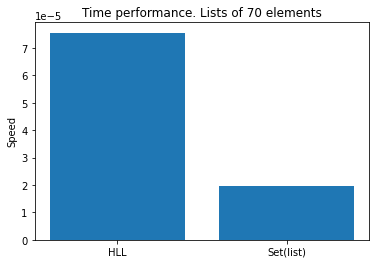

Average performance: hyperloglog - 7.552199999999232e-05, set(list) = 1.978400000000491e-05. With small lists hyperloglog is slower.


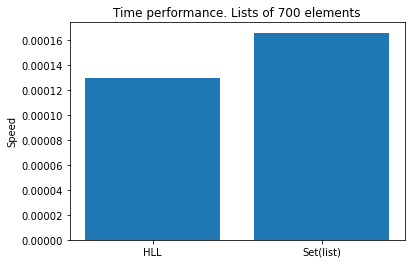

Average performance: hyperloglog - 0.00012975599999995424, set(list) = 0.00016619200000008049, hyperloglog: 22% faster


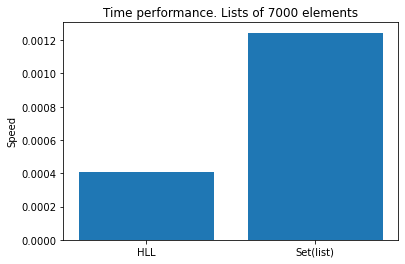

Average performance: hyperloglog - 0.00040752400000030773, set(list) = 0.0012448560000000697, hyperloglog: 67% faster


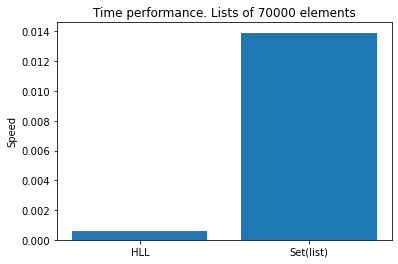

Average performance: hyperloglog - 0.0005812960000002043, set(list) = 0.013915826000001203, hyperloglog: 96% faster


In [52]:
average_values_list = []
names_list = ["HLL", "Set(list)"]
average_values_list.append(np.average(x_hll_70))
average_values_list.append(np.average(x_list_70))
plt.bar(names_list, average_values_list)
plt.title("Time performance. Lists of 70 elements")
plt.ylabel("Speed")
plt.show()
print(f"Average performance: hyperloglog - {np.average(x_hll_70)}, set(list) = {np.average(x_list_70)}. With small lists hyperloglog is slower.")

average_values_list = []
names_list = ["HLL", "Set(list)"]
average_values_list.append(np.average(x_hll))
average_values_list.append(np.average(x_list))
plt.bar(names_list, average_values_list)
plt.title("Time performance. Lists of 700 elements")
plt.ylabel("Speed")
plt.show()
print(f"Average performance: hyperloglog - {np.average(x_hll)}, set(list) = {np.average(x_list)}, hyperloglog: {100 - ((np.average(x_hll)/np.average(x_list)) * 100):.2n}% faster")


average_values_list = []
names_list = ["HLL", "Set(list)"]
average_values_list.append(np.average(x_hll_7000))
average_values_list.append(np.average(x_list_7000))
plt.bar(names_list, average_values_list)
plt.title("Time performance. Lists of 7000 elements")
plt.ylabel("Speed")
plt.show()
print(f"Average performance: hyperloglog - {np.average(x_hll_7000)}, set(list) = {np.average(x_list_7000)}, hyperloglog: {100 - ((np.average(x_hll_7000)/np.average(x_list_7000)) * 100):.2n}% faster")

average_values_list = []
names_list = ["HLL", "Set(list)"]
average_values_list.append(np.average(x_hll_70_000))
average_values_list.append(np.average(x_list_70_000))
plt.bar(names_list, average_values_list)
plt.title("Time performance. Lists of 70000 elements")
plt.ylabel("Speed")
plt.show()
print(f"Average performance: hyperloglog - {np.average(x_hll_70_000)}, set(list) = {np.average(x_list_70_000)}, hyperloglog: {100 - ((np.average(x_hll_70_000)/np.average(x_list_70_000)) * 100):.2n}% faster")


In regard to big numbers, hyperloglog speed performance is obviously better.

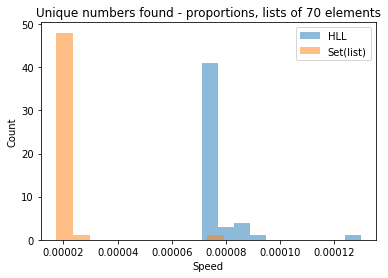

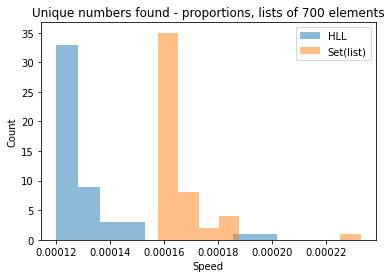

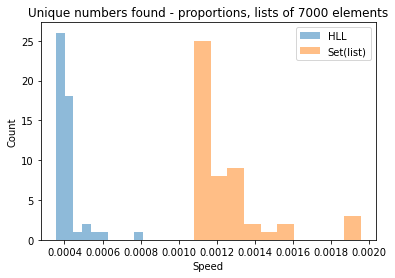

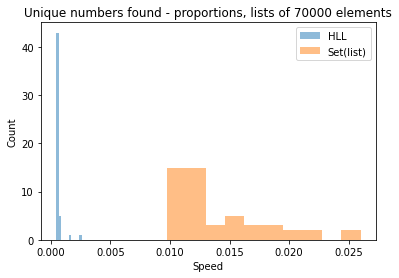

In [29]:
plt.hist(x_hll_70, alpha=0.5, label='HLL')
plt.hist(x_list_70, alpha=0.5, label='Set(list)')
plt.xlabel("Speed")
plt.ylabel("Count")
plt.title("Unique numbers found - proportions, lists of 70 elements")
plt.legend(loc='upper right')
plt.show()

plt.hist(x_hll, alpha=0.5, label='HLL')
plt.hist(x_list, alpha=0.5, label='Set(list)')
plt.xlabel("Speed")
plt.ylabel("Count")
plt.title("Unique numbers found - proportions, lists of 700 elements")
plt.legend(loc='upper right')
plt.show()

plt.hist(x_hll_7000, alpha=0.5, label='HLL')
plt.hist(x_list_7000, alpha=0.5, label='Set(list)')
plt.xlabel("Speed")
plt.ylabel("Count")
plt.title("Unique numbers found - proportions, lists of 7000 elements")
plt.legend(loc='upper right')
plt.show()

plt.hist(x_hll_70_000, alpha=0.5, label='HLL')
plt.hist(x_list_70_000, alpha=0.5, label='Set(list)')
plt.xlabel("Speed")
plt.ylabel("Count")
plt.title("Unique numbers found - proportions, lists of 70000 elements")
plt.legend(loc='upper right')
plt.show()

It seems that both functions experience similar difficulties and delays with the lists of 700 elements. When they should cope with 7000- and 70000-element lists though hyperloglog`s function performs smoothly, without much delay.

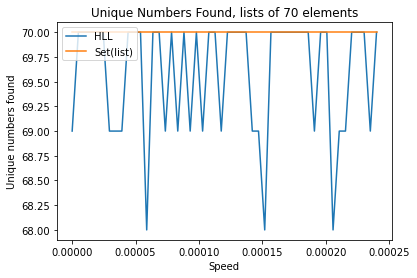

Average unique elements found by hyperloglog: 69.58
Hyperloglog missed around 0.6% unique elements


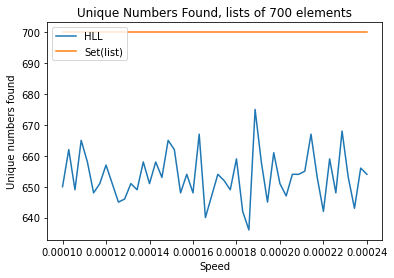

Average unique elements found by hyperloglog: 653.36
Hyperloglog missed around 6.663% unique elements


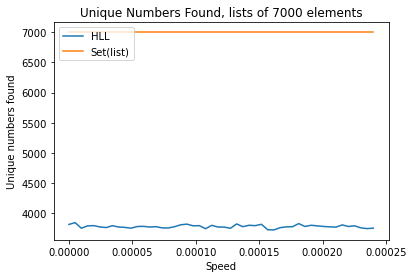

Average unique elements found by hyperloglog: 3777.4
Hyperloglog missed around 46.04% unique elements


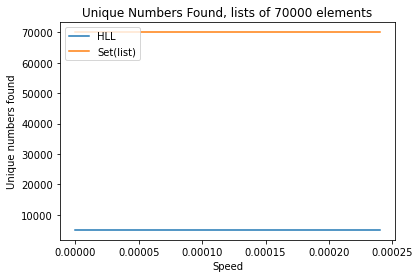

Average unique elements found by hyperloglog: 5027.0
Hyperloglog missed around 92.82% unique elements


In [43]:
fig, ax = plt.subplots()
x = np.linspace(0.00000, 0.00024, 50)
ax.plot(x, y_hll_70, label='HLL')
ax.plot(x, y_list_70, label='Set(list)')
plt.xlabel("Speed")
plt.ylabel("Unique numbers found")
plt.title("Unique Numbers Found, lists of 70 elements")
plt.legend(loc='upper left')
plt.show()

print(f"Average unique elements found by hyperloglog: {np.average(y_hll_70)}")
print(f"Hyperloglog missed around {(np.average(y_list_70 - np.average(y_hll_70)) / np.average(y_list_70)) * 100:.4n}% unique elements")

fig, ax = plt.subplots()
x = np.linspace(0.00010, 0.00024, 50)
ax.plot(x, y_hll, label='HLL')
ax.plot(x, y_list, label='Set(list)')
plt.xlabel("Speed")
plt.ylabel("Unique numbers found")
plt.title("Unique Numbers Found, lists of 700 elements")
plt.legend(loc='upper left')
plt.show()

print(f"Average unique elements found by hyperloglog: {np.average(y_hll)}")
print(f"Hyperloglog missed around {((np.average(y_list) - np.average(y_hll)) / np.average(y_list)) * 100:.4n}% unique elements")

fig, ax = plt.subplots()
x = np.linspace(0.00000, 0.00024, 50)
ax.plot(x, y_hll_7000, label='HLL')
ax.plot(x, y_list_7000, label='Set(list)')
plt.xlabel("Speed")
plt.ylabel("Unique numbers found")
plt.title("Unique Numbers Found, lists of 7000 elements")
plt.legend(loc='upper left')
plt.show()

print(f"Average unique elements found by hyperloglog: {np.average(y_hll_7000)}")
print(f"Hyperloglog missed around {(np.average(y_list_7000 - np.average(y_hll_7000)) / np.average(y_list_7000)) * 100:.4n}% unique elements")

fig, ax = plt.subplots()
x = np.linspace(0.00000, 0.00024, 50)
ax.plot(x, y_hll_70_000, label='HLL')
ax.plot(x, y_list_70_000, label='Set(list)')
plt.xlabel("Speed")
plt.ylabel("Unique numbers found")
plt.title("Unique Numbers Found, lists of 70000 elements")
plt.legend(loc='upper left')
plt.show()

print(f"Average unique elements found by hyperloglog: {np.average(y_hll_70_000)}")
print(f"Hyperloglog missed around {(np.average(y_list_70_000 - np.average(y_hll_70_000)) / np.average(y_list_70_000)) * 100:.4n}% unique elements")



The number of unique elements missed gets bigger and bigger with the growth of lists. The error goes far beyond 1.04/√m.  More reliable HyperLogLog implementation is needed for more precise tests.

### References

<a id='Cell1'>[1]</a> Vijini Mallawaarachchi. "8 Common Data Structures every Programmer must know". https://towardsdatascience.com/8-common-data-structures-every-programmer-must-know-171acf6a1a42. Accessed 19 May 2021.

<a id='Cell2'>[2]</a> Aditya Chatterjee, Ethan Z. Booker. Probabilistic Data Structures. 
https://iq.opengenus.org/probabilistic-data-structures/. Accessed 19 May 2021.

<a id='Cell3'>[3]</a> Philippe Flajolet, Éric Fusy, Olivier Gandouet, Frédéric Meunier. HyperLogLog: the analysis of a near-optimal
cardinality estimation algorithm. http://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf. Accessed 19 May 2021.

<a id='Cell4'>[4]</a> Georgi Georgiev. The Effect of Using Cardinality Estimates Like HyperLogLog in Statistical Analyses. https://blog.analytics-toolkit.com/2020/the-effect-of-using-cardinality-estimates-like-hyperloglog-in-statistical-analyses/. Accessed 19 May 2021.

<a id='Cell5'>[5]</a> Gaurav Sen. Hyperloglog: Facebook's algorithm to count distinct elements. https://www.youtube.com/watch?v=eV1haPUt0NU. Accessed 19 May 2021.

<a id='Cell6'>[6]</a> Gonzalo Bordanzi. Hyperloglog: Obtaining the cardinality of a set in a probabilistic way. https://blog.devartis.com/hyperloglogs-a-probabilistic-way-of-obtaining-a-sets-cardinality-3b5e6a982a12. Accessed 19 May 2021.

<a id='Cell7'>[7]</a> http://blog.aggregateknowledge.com/2012/10/25/sketch-of-the-day-hyperloglog-cornerstone-of-a-big-data-infrastructure/

<a id='Cell8'>[8]</a> Brian Kihoon Lee. Using Linear Counting, LogLog, and HyperLogLog to Estimate Cardinality. https://www.moderndescartes.com/essays/hyperloglog/. Accessed 19 May 2021.

<a id='Cell9'>[9]</a> HyperLogLog. https://en.wikipedia.org/wiki/HyperLogLog. Accessed 19 May 2021.

<a id='Cell10'>[10]</a> Krishnan Chandra. View Counting at Reddit. https://redditblog.com/2017/05/24/view-counting-at-reddit/. Accessed 19 May 2021.

<a id='Cell11'>[11]</a> Alessandro Nadalin. My favorite algorithm (and data structure): HyperLogLog. https://odino.org/my-favorite-data-structure-hyperloglog/. Accessed 20 May 2021.